In [53]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1we8z_DgA0snNT8PyzFNYFTibkCK2JdUf


Downloading...
From: https://drive.google.com/uc?id=1we8z_DgA0snNT8PyzFNYFTibkCK2JdUf
To: /content/ballbeam.dat.gz
100% 7.37k/7.37k [00:00<00:00, 24.3MB/s]


In [48]:
import numpy as np

# بارگذاری داده‌ها
data = np.loadtxt('ballbeam.dat')
U = data[:, 0]  # زاویه تیر
Y = data[:, 1]  # موقعیت توپ

# تقسیم داده‌ها به مجموعه آموزشی و تست
train_data = np.column_stack((U[:800], Y[:800]))  # مجموعه آموزشی
test_data = np.column_stack((U[800:], Y[800:]))  # مجموعه تست


Epoch [10/500], Loss: 0.154118
Epoch [20/500], Loss: 0.079509
Epoch [30/500], Loss: 0.063213
Epoch [40/500], Loss: 0.049453
Epoch [50/500], Loss: 0.040847
Epoch [60/500], Loss: 0.036535
Epoch [70/500], Loss: 0.032407
Epoch [80/500], Loss: 0.031022
Epoch [90/500], Loss: 0.028414
Epoch [100/500], Loss: 0.027688
Epoch [110/500], Loss: 0.026539
Epoch [120/500], Loss: 0.025933
Epoch [130/500], Loss: 0.025078
Epoch [140/500], Loss: 0.024584
Epoch [150/500], Loss: 0.023644
Epoch [160/500], Loss: 0.023508
Epoch [170/500], Loss: 0.022613
Epoch [180/500], Loss: 0.022131
Epoch [190/500], Loss: 0.022593
Epoch [200/500], Loss: 0.021175
Epoch [210/500], Loss: 0.022218
Epoch [220/500], Loss: 0.022401
Epoch [230/500], Loss: 0.021713
Epoch [240/500], Loss: 0.022196
Epoch [250/500], Loss: 0.022299
Epoch [260/500], Loss: 0.022702
Epoch [270/500], Loss: 0.021523
Epoch [280/500], Loss: 0.022011
Epoch [290/500], Loss: 0.021766
Epoch [300/500], Loss: 0.021516
Epoch [310/500], Loss: 0.022206
Epoch [320/500], 

<ipython-input-50-775d6b585880>:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  anfis_model.load_state_dict(torch.load("best_anfis.pth"))


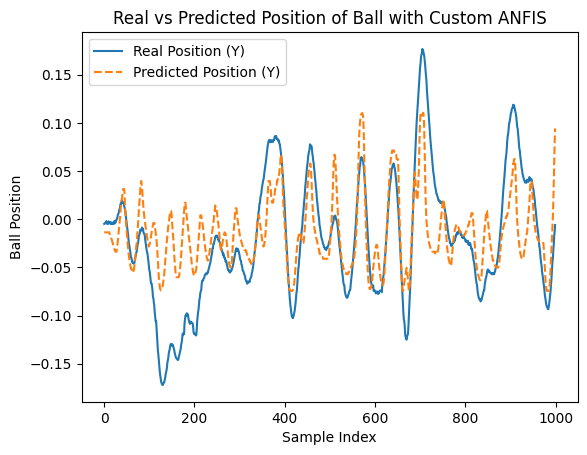

In [50]:
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. بارگذاری داده‌ها
data = np.loadtxt("ballbeam.dat")
U = data[:, 0].reshape(-1, 1)  # زاویه تیر (ورودی)
Y = data[:, 1].reshape(-1, 1)  # موقعیت توپ (خروجی)

# 2. نرمال‌سازی داده‌ها
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
U_norm = scaler_X.fit_transform(U)
Y_norm = scaler_Y.fit_transform(Y)

# 3. تبدیل داده‌ها به `torch.Tensor`
U_tensor = torch.tensor(U_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_norm, dtype=torch.float32)

# 4. تعریف توابع عضویت گاوسی
def gaussian(x, mean, sigma):
    return torch.exp(-0.5 * ((x - mean) / sigma) ** 2)

# 5. مدل ANFIS سفارشی
class ANFIS(nn.Module):
    def __init__(self, n_rules=10):
        super(ANFIS, self).__init__()
        self.n_rules = n_rules

        # پارامترهای توابع عضویت گاوسی
        self.means = nn.Parameter(torch.linspace(0, 1, n_rules))
        self.sigmas = nn.Parameter(torch.ones(n_rules) * 0.2)  # مقدار sigma کاهش یافت

        # پارامترهای نتیجه قوانین فازی
        self.weights = nn.Parameter(torch.rand(n_rules, 1))
        self.bias = nn.Parameter(torch.rand(1))

        # Dropout برای جلوگیری از overfitting
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # 1. محاسبه عضویت فازی
        memberships = torch.cat([gaussian(x, self.means[i], self.sigmas[i]) for i in range(self.n_rules)], dim=1)

        # 2. اضافه کردن Dropout
        memberships = self.dropout(memberships)

        # 3. وزن‌دهی قوانین فازی
        rule_outputs = memberships @ self.weights.squeeze()

        # 4. خروجی نهایی همراه با بایاس و محدود کردن در بازه [0,1]
        output = torch.sigmoid(rule_outputs + self.bias)

        return output.unsqueeze(1)  # تبدیل به شکل (batch_size, 1)

# 6. تعریف مدل و بهینه‌ساز
anfis_model = ANFIS(n_rules=10)
optimizer = optim.Adam(anfis_model.parameters(), lr=0.01)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# 7. آموزش مدل با Early Stopping
num_epochs = 500
best_loss = float('inf')

def train_anfis(model, optimizer, criterion, U, Y, scheduler):
    global best_loss
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(U)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        # کاهش نرخ یادگیری اگر پیشرفت کم باشد
        scheduler.step(loss)

        # ذخیره بهترین مدل
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), "best_anfis.pth")

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

train_anfis(anfis_model, optimizer, criterion, U_tensor, Y_tensor, scheduler)

# 8. بارگذاری بهترین مدل ذخیره‌شده
anfis_model.load_state_dict(torch.load("best_anfis.pth"))
anfis_model.eval()

# 9. پیش‌بینی با مدل آموزش‌دیده‌شده
y_pred = anfis_model(U_tensor).detach().numpy()
y_pred_real = scaler_Y.inverse_transform(y_pred)  # بازگرداندن مقیاس به مقدار واقعی

# 10. ارزیابی مدل
rmse = np.sqrt(mean_squared_error(Y, y_pred_real))
print(f'Final RMSE: {rmse:.4f}')

# 11. نمایش نتایج
plt.plot(Y, label='Real Position (Y)')
plt.plot(y_pred_real, label='Predicted Position (Y)', linestyle='dashed')
plt.title("Real vs Predicted Position of Ball with Custom ANFIS")
plt.xlabel("Sample Index")
plt.ylabel("Ball Position")
plt.legend()
plt.show()


In [55]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1X_9Wj_0LfKgoNL4zp-8FZ25TfKqXVFj6

Downloading...
From: https://drive.google.com/uc?id=1X_9Wj_0LfKgoNL4zp-8FZ25TfKqXVFj6
To: /content/steamgen.dat.gz
100% 831k/831k [00:00<00:00, 10.8MB/s]


Epoch [10/500], Loss: 0.1952
Epoch [20/500], Loss: 0.1629
Epoch [30/500], Loss: 0.1404
Epoch [40/500], Loss: 0.1230
Epoch [50/500], Loss: 0.1092
Epoch [60/500], Loss: 0.0983
Epoch [70/500], Loss: 0.0894
Epoch [80/500], Loss: 0.0823
Epoch [90/500], Loss: 0.0763
Epoch [100/500], Loss: 0.0714
Epoch [110/500], Loss: 0.0674
Epoch [120/500], Loss: 0.0641
Epoch [130/500], Loss: 0.0614
Epoch [140/500], Loss: 0.0592
Epoch [150/500], Loss: 0.0574
Epoch [160/500], Loss: 0.0561
Epoch [170/500], Loss: 0.0550
Epoch [180/500], Loss: 0.0542
Epoch [190/500], Loss: 0.0535
Epoch [200/500], Loss: 0.0530
Epoch [210/500], Loss: 0.0526
Epoch [220/500], Loss: 0.0523
Epoch [230/500], Loss: 0.0520
Epoch [240/500], Loss: 0.0507
Epoch [250/500], Loss: 0.0448
Epoch [260/500], Loss: 0.0396
Epoch [270/500], Loss: 0.0369
Epoch [280/500], Loss: 0.0352
Epoch [290/500], Loss: 0.0337
Epoch [300/500], Loss: 0.0326
Epoch [310/500], Loss: 0.0316
Epoch [320/500], Loss: 0.0308
Epoch [330/500], Loss: 0.0301
Epoch [340/500], Lo

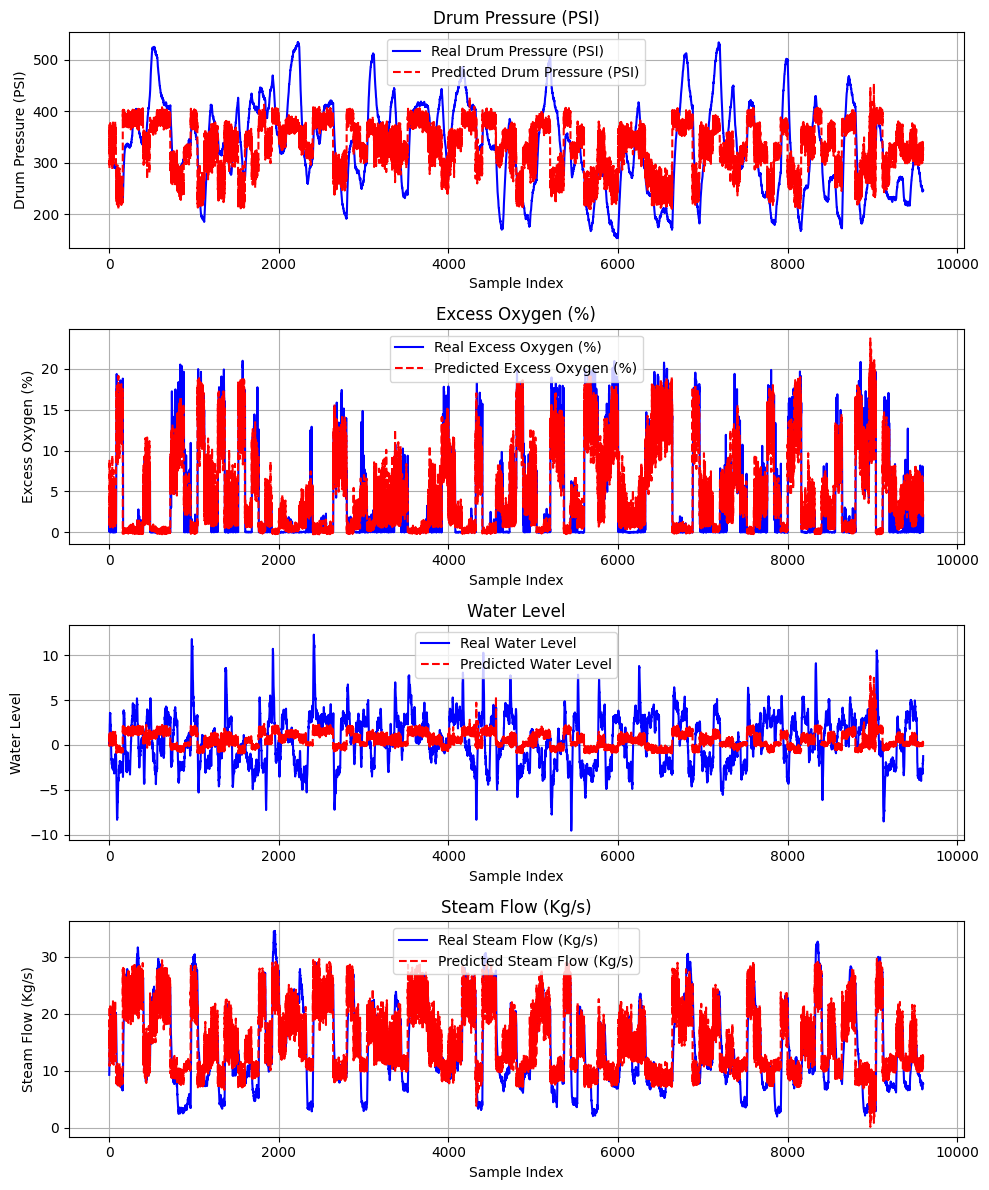

In [62]:
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. بارگذاری داده‌ها
data = np.loadtxt("steamgen.dat")
U = data[:, 1:5]  # ورودی‌ها: سوخت، هوا، سطح مرجع، اغتشاش
Y = data[:, 5:9]  # خروجی‌ها: فشار درام، اکسیژن اضافی، سطح آب، جریان بخار

# 2. نرمال‌سازی داده‌ها
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
U_norm = scaler_X.fit_transform(U)
Y_norm = scaler_Y.fit_transform(Y)

# 3. تبدیل داده‌ها به `torch.Tensor`
U_tensor = torch.tensor(U_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_norm, dtype=torch.float32)

# 4. تعریف تابع عضویت گاوسی
def gaussian(x, mean, sigma):
    return torch.exp(-0.5 * ((x - mean) / sigma) ** 2)

# 5. مدل ANFIS
class ANFIS(nn.Module):
    def __init__(self, n_rules=10, n_inputs=4):
        super(ANFIS, self).__init__()
        self.n_rules = n_rules
        self.n_inputs = n_inputs

        # پارامترهای توابع عضویت گاوسی
        self.means = nn.Parameter(torch.rand(n_rules, n_inputs))
        self.sigmas = nn.Parameter(torch.rand(n_rules, n_inputs) * 0.1 + 0.1)

        # وزن‌های خروجی
        self.weights = nn.Parameter(torch.rand(n_rules, 4))
        self.bias = nn.Parameter(torch.rand(4))

    def forward(self, x):
        batch_size = x.shape[0]

        # تنظیم ابعاد داده‌ها برای اعمال توابع عضویت
        x_expanded = x.unsqueeze(1).expand(-1, self.n_rules, -1)  # (9600, 10, 4)
        means_expanded = self.means.unsqueeze(0).expand(batch_size, -1, -1)  # (9600, 10, 4)
        sigmas_expanded = self.sigmas.unsqueeze(0).expand(batch_size, -1, -1)  # (9600, 10, 4)

        # محاسبه عضویت فازی
        memberships = torch.exp(-0.5 * ((x_expanded - means_expanded) / sigmas_expanded) ** 2)
        memberships = torch.prod(memberships, dim=2)  # ضرب عضویت‌ها

        # وزن‌دهی قوانین فازی
        rule_outputs = memberships @ self.weights

        # خروجی نهایی
        output = rule_outputs + self.bias
        return output

# 6. تعریف مدل و بهینه‌ساز
anfis_model = ANFIS(n_rules=10, n_inputs=4)
optimizer = optim.AdamW(anfis_model.parameters(), lr=0.005, weight_decay=1e-3)
criterion = nn.MSELoss()

# 7. آموزش مدل
num_epochs = 500
def train_anfis(model, optimizer, criterion, U, Y):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(U)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_anfis(anfis_model, optimizer, criterion, U_tensor, Y_tensor)

# 8. پیش‌بینی با مدل آموزش‌دیده‌شده
y_pred = anfis_model(U_tensor).detach().numpy()
y_pred_real = scaler_Y.inverse_transform(y_pred)  # بازگرداندن به مقیاس واقعی

# 9. ارزیابی مدل
rmse = np.sqrt(mean_squared_error(Y, y_pred_real))
print(f'Final RMSE: {rmse:.4f}')

# 10. نمایش نتایج
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))  # ۴ نمودار زیر هم

outputs_real = [Y[:, i] for i in range(4)]  # خروجی‌های واقعی
outputs_pred = [y_pred_real[:, i] for i in range(4)]  # خروجی‌های پیش‌بینی‌شده
titles = ["Drum Pressure (PSI)", "Excess Oxygen (%)", "Water Level", "Steam Flow (Kg/s)"]

for i, ax in enumerate(axes):
    ax.plot(outputs_real[i], label=f"Real {titles[i]}", color="blue")
    ax.plot(outputs_pred[i], label=f"Predicted {titles[i]}", linestyle="dashed", color="red")
    ax.set_title(titles[i])
    ax.set_xlabel("Sample Index")
    ax.set_ylabel(titles[i])
    ax.legend()
    ax.grid(True)

plt.tight_layout()  # تنظیم فاصله‌ها
plt.show()


Epoch [10/500], Train Loss: 0.1707, Validation Loss: 0.1703
Epoch [20/500], Train Loss: 0.1382, Validation Loss: 0.1386
Epoch [30/500], Train Loss: 0.1110, Validation Loss: 0.1121
Epoch [40/500], Train Loss: 0.0905, Validation Loss: 0.0926
Epoch [50/500], Train Loss: 0.0765, Validation Loss: 0.0788
Epoch [60/500], Train Loss: 0.0743, Validation Loss: 0.0776
Epoch [70/500], Train Loss: 0.0732, Validation Loss: 0.0765
Epoch [80/500], Train Loss: 0.0722, Validation Loss: 0.0754
Epoch [90/500], Train Loss: 0.0712, Validation Loss: 0.0744
Epoch [100/500], Train Loss: 0.0702, Validation Loss: 0.0733
Epoch [110/500], Train Loss: 0.0700, Validation Loss: 0.0732
Epoch [120/500], Train Loss: 0.0699, Validation Loss: 0.0731
Epoch [130/500], Train Loss: 0.0698, Validation Loss: 0.0730
Epoch [140/500], Train Loss: 0.0697, Validation Loss: 0.0729
Epoch [150/500], Train Loss: 0.0696, Validation Loss: 0.0728
Epoch [160/500], Train Loss: 0.0696, Validation Loss: 0.0728
Epoch [170/500], Train Loss: 0.06

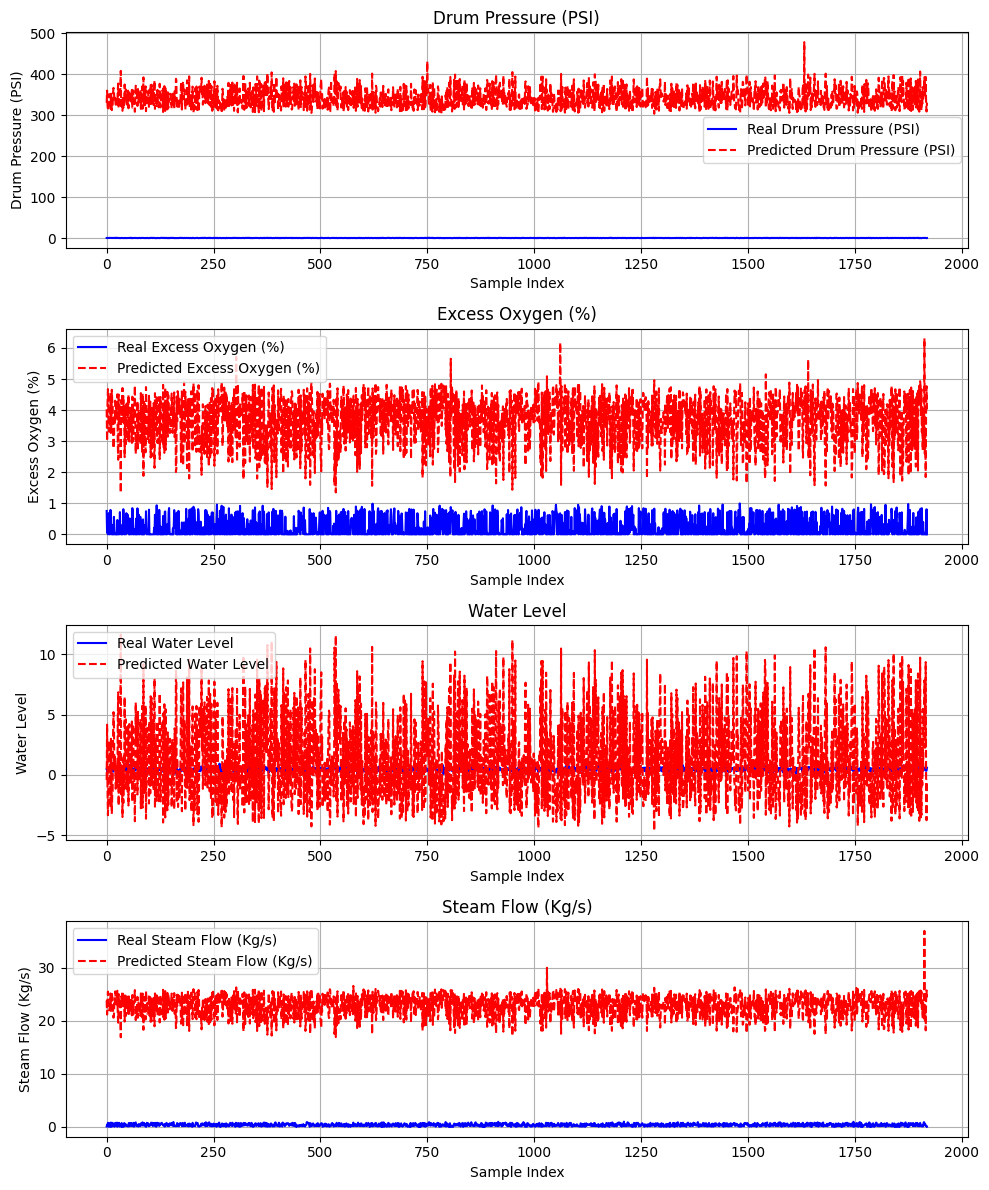

In [63]:
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. بارگذاری داده‌ها
data = np.loadtxt("steamgen.dat")
U = data[:, 1:5]  # ورودی‌ها: سوخت، هوا، سطح مرجع، اغتشاش
Y = data[:, 5:9]  # خروجی‌ها: فشار درام، اکسیژن اضافی، سطح آب، جریان بخار

# 2. نرمال‌سازی داده‌ها
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
U_norm = scaler_X.fit_transform(U)
Y_norm = scaler_Y.fit_transform(Y)

# 3. تبدیل داده‌ها به `torch.Tensor`
U_tensor = torch.tensor(U_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_norm, dtype=torch.float32)

# 4. تعریف تابع عضویت گاوسی
def gaussian(x, mean, sigma):
    return torch.exp(-0.5 * ((x - mean) / sigma) ** 2)

# 5. مدل ANFIS
class ANFIS(nn.Module):
    def __init__(self, n_rules=10, n_inputs=4):
        super(ANFIS, self).__init__()
        self.n_rules = n_rules
        self.n_inputs = n_inputs

        # پارامترهای توابع عضویت گاوسی
        self.means = nn.Parameter(torch.rand(n_rules, n_inputs))
        self.sigmas = nn.Parameter(torch.rand(n_rules, n_inputs) * 0.1 + 0.1)

        # وزن‌های خروجی
        self.weights = nn.Parameter(torch.rand(n_rules, 4))
        self.bias = nn.Parameter(torch.rand(4))

    def forward(self, x):
        batch_size = x.shape[0]

        # تنظیم ابعاد داده‌ها برای اعمال توابع عضویت
        x_expanded = x.unsqueeze(1).expand(-1, self.n_rules, -1)  # (9600, 10, 4)
        means_expanded = self.means.unsqueeze(0).expand(batch_size, -1, -1)  # (9600, 10, 4)
        sigmas_expanded = self.sigmas.unsqueeze(0).expand(batch_size, -1, -1)  # (9600, 10, 4)

        # محاسبه عضویت فازی
        memberships = torch.exp(-0.5 * ((x_expanded - means_expanded) / sigmas_expanded) ** 2)
        memberships = torch.prod(memberships, dim=2)  # ضرب عضویت‌ها

        # وزن‌دهی قوانین فازی
        rule_outputs = memberships @ self.weights

        # خروجی نهایی
        output = rule_outputs + self.bias
        return output

# 6. تعریف مدل و بهینه‌ساز
anfis_model = ANFIS(n_rules=10, n_inputs=4)
optimizer = optim.AdamW(anfis_model.parameters(), lr=0.005, weight_decay=1e-3)
criterion = nn.MSELoss()

# 7. آموزش مدل
num_epochs = 500
def train_anfis(model, optimizer, criterion, U, Y):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(U)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_anfis(anfis_model, optimizer, criterion, U_tensor, Y_tensor)

# 8. پیش‌بینی با مدل آموزش‌دیده‌شده
y_pred = anfis_model(U_tensor).detach().numpy()
y_pred_real = scaler_Y.inverse_transform(y_pred)  # بازگرداندن به مقیاس واقعی

# 9. محاسبه RMSE برای هر خروجی
rmse_values = []
for i in range(4):
    rmse = np.sqrt(mean_squared_error(Y[:, i], y_pred_real[:, i]))
    rmse_values.append(rmse)
    print(f'RMSE for {["Drum Pressure", "Excess Oxygen", "Water Level", "Steam Flow"][i]}: {rmse:.4f}')

# 10. نمایش نتایج
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))  # ۴ نمودار زیر هم

outputs_real = [Y[:, i] for i in range(4)]  # خروجی‌های واقعی
outputs_pred = [y_pred_real[:, i] for i in range(4)]  # خروجی‌های پیش‌بینی‌شده
titles = ["Drum Pressure (PSI)", "Excess Oxygen (%)", "Water Level", "Steam Flow (Kg/s)"]

for i, ax in enumerate(axes):
    ax.plot(outputs_real[i], label=f"Real {titles[i]}", color="blue")
    ax.plot(outputs_pred[i], label=f"Predicted {titles[i]}", linestyle="dashed", color="red")
    ax.set_title(titles[i])
    ax.set_xlabel("Sample Index")
    ax.set_ylabel(titles[i])
    ax.legend()
    ax.grid(True)

plt.tight_layout()  # تنظیم فاصله‌ها
plt.show()
